# Mass-Spring Underdamped Oscillator

$$m \frac{d^2 x}{dt^2} + c \frac{dx}{dt} + k x = 0$$

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

class OscillatorPINN(nn.Module):
    def __init__(self, num_layers, num_neurons, m, k, c):
        super(OscillatorPINN, self).__init__()
        self.layers = []
        self.m = m
        self.k = k
        self.c = c
        
        self.layers.append(nn.Linear(1, num_neurons))  # Add input layer
        self.layers.append(nn.Tanh())

        for _ in range(num_layers-2):  # Change the range to account for the input layer
            self.layers.append(nn.Linear(num_neurons, num_neurons))
            self.layers.append(nn.Tanh())
        self.layers.append(nn.Linear(num_neurons, 1))
        
        self.model = nn.Sequential(*self.layers)
    
    def forward(self, t):
        return self.model(t)
    
    def loss(self, t_f, t_u, x_u, x0, v0):
        x_f = self(t_f)
        x_f_t = self.time_derivative(x_f, t_f)
        x_f_tt = self.time_derivative(x_f_t, t_f)

        # Mass-spring-damper governing equation: m * x_tt + c * x_t + k * x = 0
        f = self.m * x_f_tt + self.c * x_f_t + self.k * x_f

        mse = nn.MSELoss()
        loss_f = mse(f, torch.zeros_like(f))

        # Loss for the training data
        loss_u = mse(self(t_u), x_u)

        # Enforce initial conditions
        t0 = torch.tensor([[0.0]], dtype=torch.float32, requires_grad=True)
        x_init = self(t0)
        x_t_init = self.time_derivative(x_init, t0)

        loss_bc = mse(x_init, torch.tensor([[x0]], dtype=torch.float32)) + mse(x_t_init, torch.tensor([[v0]], dtype=torch.float32))

        loss = loss_f + loss_u + loss_bc
        # loss = 0.1 * loss_f + 0.9 * loss_u
        return loss

    def time_derivative(self, x, t):
        return torch.autograd.grad(x, t, grad_outputs=torch.ones_like(x), create_graph=True)[0]

In [2]:
# Train the model
def train(model, t_f, t_u, x_u, x0, v0, epochs, lr):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = model.loss(t_f, t_u, x_u, x0, v0)
        loss.backward()
        optimizer.step()

        if epoch % 100 == 0:
            print(f"Epoch: {epoch}, Loss: {loss.item()}")

In [3]:
# Mass-spring-damper system parameters
m = 2.0
k = 20.0
zeta = 0.1  # Smaller damping ratio for slower energy dissipation
c = 2 * zeta * np.sqrt(m * k)

# Time values for training data
# t_train = np.linspace(0, 20, 10)
t_u = np.linspace(0, 3, 10)

# Angular frequency and damping ratio
omega0 = np.sqrt(k / m)
omega_d = omega0 * np.sqrt(1 - zeta**2)

# Calculate the exponential and oscillatory components
exp_term = np.exp(-zeta * omega0 * t_u)
osc_term = np.cos(omega_d * t_u) + (zeta / np.sqrt(1 - zeta**2)) * np.sin(omega_d * t_u)

# # Mass-spring-damper system parameters
# m = 2.0
# k = 20.0
# c = 2.0 * np.sqrt(m * k) * 0.5  # Damping ratio = 0.5 (underdamped)

# # Angular frequency and damping ratio
# omega0 = np.sqrt(k / m)
# zeta = c / (2 * np.sqrt(m * k))

In [4]:
# Initial conditions
x0 = 1.0  # Initial displacement
v0 = 0.0  # Initial velocity

# Displacement, velocity, and acceleration
x_u = x0 * exp_term * osc_term

# Convert to PyTorch tensors
x_u_tensor = torch.tensor(x_u, dtype=torch.float32).unsqueeze(1)
t_u_tensor = torch.tensor(t_u, dtype=torch.float32, requires_grad=True).unsqueeze(1)

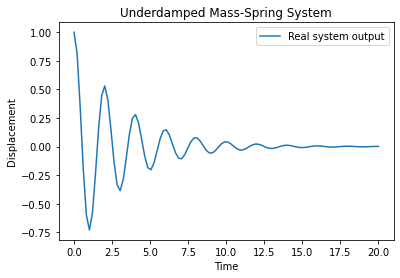

In [5]:
# Real system
t_real = np.linspace(0, 20, 100)

# Calculate the exponential and oscillatory components
exp_term_real = np.exp(-zeta * omega0 * t_real)
omega_d_real = omega0 * np.sqrt(1 - zeta**2)
osc_term_real = np.cos(omega_d_real * t_real) + (zeta / np.sqrt(1 - zeta**2)) * np.sin(omega_d_real * t_real)

# Displacement, velocity, and acceleration
x_real = x0 * exp_term_real * osc_term_real

# Convert to PyTorch tensors
t_real_tensor = torch.tensor(t_real, dtype=torch.float32, requires_grad=True).unsqueeze(1)

# Visualize the results
plt.plot(t_real, x_real, label='Real system output')
plt.xlabel('Time')
plt.ylabel('Displacement')
plt.legend()
plt.title('Underdamped Mass-Spring System')
plt.show()

In [6]:
# PINN model
num_layers = 4
num_neurons = 64
model = OscillatorPINN(num_layers, num_neurons, m, k, c)
print(model)

OscillatorPINN(
  (model): Sequential(
    (0): Linear(in_features=1, out_features=64, bias=True)
    (1): Tanh()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): Tanh()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): Tanh()
    (6): Linear(in_features=64, out_features=1, bias=True)
  )
)


In [9]:
# Train the model
epochs = 30000
lr = 1e-3

t_f = np.linspace(0, 20, 100) # collocation points
t_f_tensor = torch.tensor(t_f, dtype=torch.float32, requires_grad=True).unsqueeze(1)

train(model, t_f_tensor, t_u_tensor, x_u_tensor, x0, v0, epochs, lr)

# Test the trained model
t_test = np.linspace(0, 20, 100)
t_test_tensor = torch.tensor(t_test, dtype=torch.float32, requires_grad=True).unsqueeze(1)
x_pred = model(t_test_tensor).detach().numpy()

Epoch: 0, Loss: 0.1436922550201416
Epoch: 100, Loss: 0.053975388407707214
Epoch: 200, Loss: 0.05263655260205269
Epoch: 300, Loss: 0.05189637467265129
Epoch: 400, Loss: 0.05108581483364105
Epoch: 500, Loss: 0.05009837821125984
Epoch: 600, Loss: 0.04889591410756111
Epoch: 700, Loss: 0.04746587947010994
Epoch: 800, Loss: 0.04647728428244591
Epoch: 900, Loss: 0.04465129226446152
Epoch: 1000, Loss: 0.04324256256222725
Epoch: 1100, Loss: 0.043193601071834564
Epoch: 1200, Loss: 0.04168669506907463
Epoch: 1300, Loss: 0.04071780666708946
Epoch: 1400, Loss: 0.03978840634226799
Epoch: 1500, Loss: 0.03959324210882187
Epoch: 1600, Loss: 0.038693446666002274
Epoch: 1700, Loss: 0.03776600956916809
Epoch: 1800, Loss: 0.03790426626801491
Epoch: 1900, Loss: 0.03673524782061577
Epoch: 2000, Loss: 0.03551066294312477
Epoch: 2100, Loss: 0.035490620881319046
Epoch: 2200, Loss: 0.03368845954537392
Epoch: 2300, Loss: 0.03949017450213432
Epoch: 2400, Loss: 0.03127031400799751
Epoch: 2500, Loss: 0.0481732785701

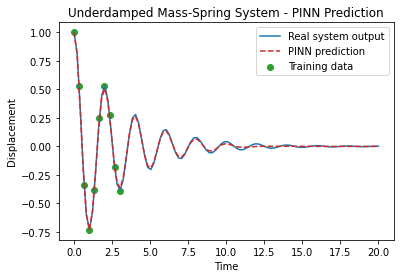

In [10]:
# Visualize the results
plt.plot(t_real, x_real, color='tab:blue', label='Real system output')
plt.plot(t_test, x_pred, '--', color='tab:red', label='PINN prediction')
plt.scatter(t_u, x_u, color='tab:green', marker='o', label='Training data')

plt.xlabel('Time')
plt.ylabel('Displacement')
plt.legend()
plt.title('Underdamped Mass-Spring System - PINN Prediction')
plt.show()